In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from tqdm import tqdm

from plot_evalue_distributions import plot_evalue_histograms, plot_evalue_kde
from complex_i_analysis import cluster_hits_with_strand, generate_subunit_data, classify_complex_types
from config import HMM_ANALYSIS_DIR, GENOME_METADATA_FILE, GENOME_DATASET_FILE

import warnings
warnings.filterwarnings('ignore')

In [2]:
results = pd.read_csv(HMM_ANALYSIS_DIR / "results_unfil.csv")

In [3]:
# Define the output directory
output_dir = HMM_ANALYSIS_DIR / "Figure"

# Ensure the directory exists
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Load datasets using paths from config.py
genomes_dataset = pd.read_csv(GENOME_DATASET_FILE)
genomes_metadata = pd.read_csv(GENOME_METADATA_FILE)

# Merge results with metadata
results = pd.merge(
    genomes_metadata.merge(results), 
    genomes_dataset[['GenomeFile', 'Species', 'Organism']], 
    on='GenomeFile'
)

In [5]:
results.head(2)

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,Start,End,log10evalue,Species,Organism
0,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,AP024266.1_4313,2.000000e-256,851.8,16.0,# 4576494 # 4578395 # 1 # ID=1_4313;partial=00...,NuoL,4576494,4578395,-255.698970,Mycobacterium intracellulare,Bacteria
1,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,AP024266.1_4308,1.300000e-234,780.4,0.0,# 4571081 # 4573495 # 1 # ID=1_4308;partial=00...,NuoG,4571081,4573495,-233.886057,Mycobacterium intracellulare,Bacteria


In [6]:
results['Species'].nunique()

10460

In [9]:
combinations = {
    'Nuo14': ['NuoA', 'NuoB', 'NuoC', 'NuoD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo13': ['NuoA', 'NuoB', 'NuoCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo12': ['NuoA', 'NuoBCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
}

colors = ["#a5b1c2", "#f7b731", "#20bf6b", "#45aaf2", "#3867d6", "#a55eea", "#0fb9b1", '#4b6584']
labels = ['Nuo-Partial', 'Nuo13', 'Nuo14', 'Nuo14-EFG', 'Nuo13-EFG', 'Nuo14-EF', 'Nuo12', 'Existing Annotation']

complex_colors = dict(zip(labels, colors))

In [10]:
# Ensure unique subunits and sorted order
all_subunits = sorted(results['Subunit'].dropna().unique())

# Remove duplicate rows
results = results.drop_duplicates()

# Apply clustering in a more efficient manner
results = results.groupby('Accession', group_keys=False).apply(cluster_hits_with_strand, intergenic_distance=250)
results.reset_index(drop=True, inplace=True)

# Generate count and boolean tables
nuo_count, nuo_bool = generate_subunit_data(results, all_subunits)

# Remove duplicate rows in boolean table
nuo_bool.drop_duplicates(inplace=True)

# Classify complex types
nuo_bool = classify_complex_types(nuo_bool, combinations, all_subunits)

# Merge species and accession information while preserving unique records
nuo_bool = nuo_bool.merge(results[['Species', 'Accession']].drop_duplicates(), on="Accession", how="left")

In [11]:
nuo_bool.head(1)

,Accession,Cluster,Strand,NuoA,NuoB,NuoBCD,NuoC,NuoCD,NuoD,NuoE,...,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation,Species
0,AAAC01000001.1,0,-1,True,True,False,True,False,True,False,...,False,True,True,True,True,True,True,True,Nuo-Partial,Bacillus anthracis


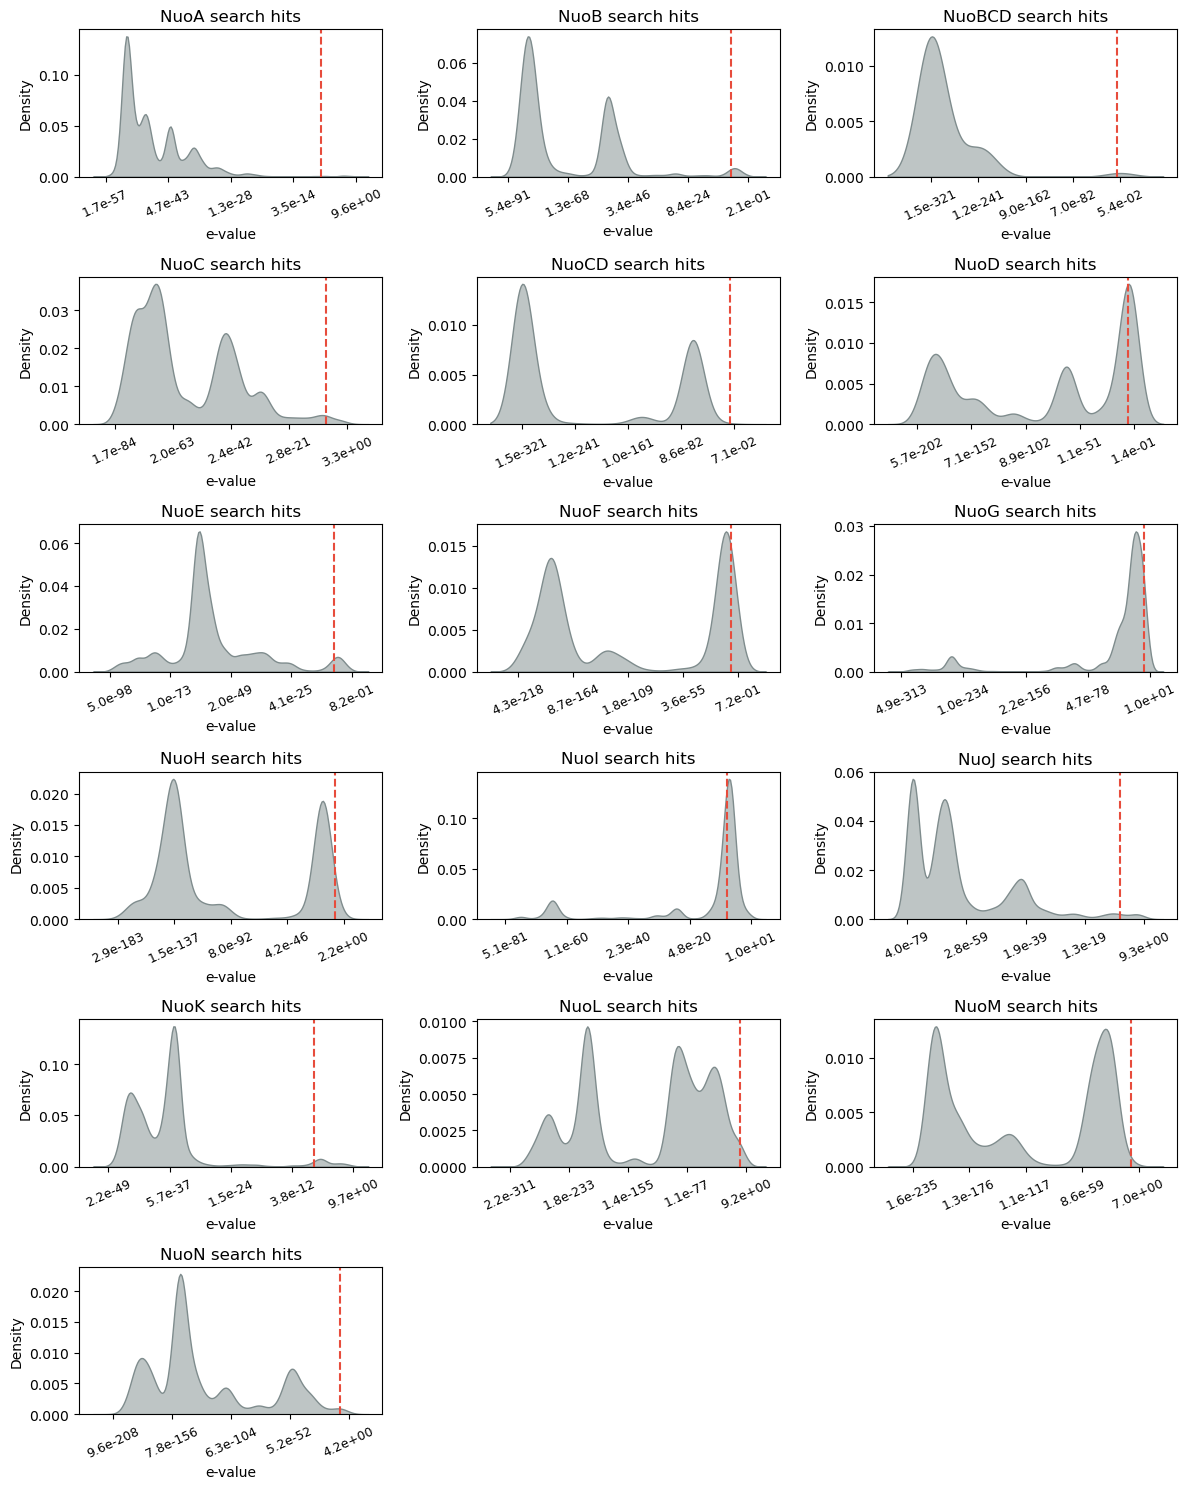

In [12]:
# List of 16 subunits
subunits = sorted(results['Subunit'].unique())

# Ensure required columns exist in both DataFrames
assert {'Accession', 'Cluster', 'Subunit'}.issubset(results.columns), "Missing expected columns in results DataFrame."
assert {'Accession', 'Cluster', 'Variation'}.issubset(nuo_bool.columns), "Missing expected columns in nuo_bool DataFrame."

# Efficiently merge data once for all subunits
subunits_data = pd.concat([
    pd.merge(
        results.reset_index(drop=True), 
        nuo_bool.loc[nuo_bool['Variation'] == arch, ['Accession', 'Cluster', 'Variation']],
        on=['Accession', 'Cluster']
    )[['Accession', 'log10evalue', 'Variation', 'Subunit']]
    for arch in nuo_bool['Variation'].unique()
], ignore_index=True)

# Handle '-inf' values in 'log10evalue' by replacing with a lower bound
finite_values = subunits_data.loc[np.isfinite(subunits_data['log10evalue']), 'log10evalue']
lower_bound = finite_values.min() - 1 if not finite_values.empty else -10  # Default lower bound
subunits_data['log10evalue'].replace(-np.inf, lower_bound, inplace=True)

# Set up figure with 3 columns and 6 rows
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 15), constrained_layout=True)
axes = axes.flatten()  # Flatten axes array for easier indexing

# Iterate over subunits and create KDE plots
for i, subunit in enumerate(subunits):
    ax = axes[i]
    
    # Filter data for the current subunit
    subunit_data = subunits_data[subunits_data['Subunit'] == subunit]

    # Skip empty plots
    if subunit_data.empty:
        ax.set_visible(False)
        continue

    # KDE Plot
    sns.kdeplot(
        data=subunit_data,
        x='log10evalue',
        color='#7f8c8d',
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=ax
    )

    # Vertical threshold line
    ax.axvline(x=-7.0, linestyle='--', color='#e74c3c')

    # Set labels and title
    ax.set_title(f'{subunit} search hits', fontsize=12)
    ax.set_xlabel('e-value', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)

    # Set custom tick labels for log-scale interpretation
    log_min = subunit_data['log10evalue'].min()
    log_max = subunit_data['log10evalue'].max()
    log_ticks = np.linspace(log_min, log_max, num=5)
    original_ticks = 10**log_ticks  # Convert log10 values back to original scale

    ax.set_xticks(log_ticks)
    ax.set_xticklabels([f'{v:.1e}' for v in original_ticks], fontsize=9, rotation=25)
    
# Hide any extra unused subplots
for i in range(len(subunits), len(axes)):
    axes[i].set_visible(False)

# Show plot
plt.tight_layout()
plt.savefig(output_dir / 'evalue_kdeplot_unfil_hits_non_clustered.png', dpi=750)
plt.savefig(output_dir / 'evalue_kdeplot_unfil_hits_non_clustered.pdf', format='pdf', dpi=750)
plt.show()

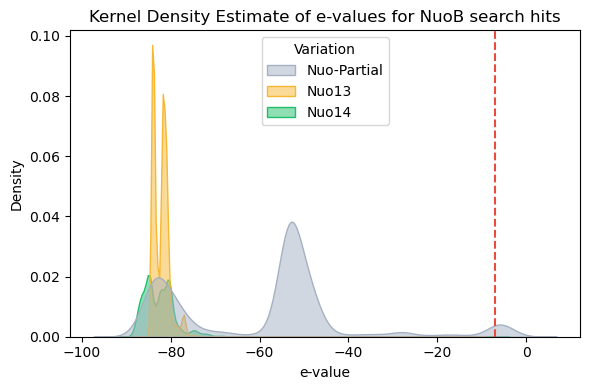

In [13]:
# Define subunit
subunit = 'NuoB'

# Efficiently merge and filter data
nuob_subunit_data = pd.concat([
    pd.merge(
        results.reset_index(drop=True), 
        nuo_bool.loc[nuo_bool['Variation'] == arch, ['Accession', 'Cluster', 'Variation']],
        on=['Accession', 'Cluster']
    ).query("Subunit == @subunit")[['Accession', 'log10evalue', 'Variation']]
    for arch in nuo_bool['Variation'].unique()
], ignore_index=True)

# Handle '-inf' values in 'log10evalue' by replacing them with a lower bound
lower_bound = nuob_subunit_data['log10evalue'][np.isfinite(nuob_subunit_data['log10evalue'])].min() - 1
nuob_subunit_data['log10evalue'].replace(-np.inf, lower_bound, inplace=True)

# Create KDE plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(
    data=nuob_subunit_data,
    x='log10evalue',
    hue='Variation',
    fill=True,
    common_norm=True,
    palette=complex_colors,
    alpha=0.5
)

ax.axvline(x=-7.0, linestyle='--', color='#e74c3c')

plt.xlabel('e-value')
plt.ylabel('Density')
plt.title(f'Kernel Density Estimate of e-values for {subunit} search hits')
plt.tight_layout()
plt.show()

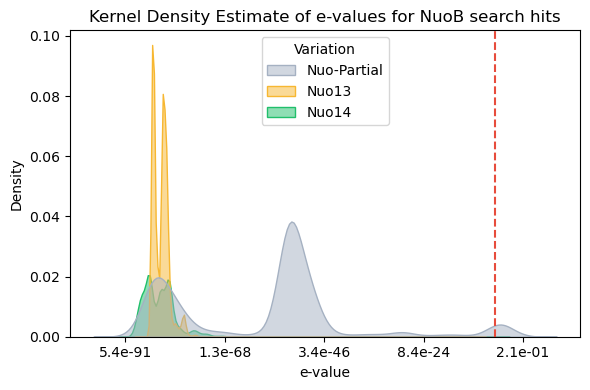

In [14]:
# Define subunit
subunit = 'NuoB'

# Efficiently merge and filter data
nuob_subunit_data = pd.concat([
    pd.merge(
        results.reset_index(drop=True), 
        nuo_bool.loc[nuo_bool['Variation'] == arch, ['Accession', 'Cluster', 'Variation']],
        on=['Accession', 'Cluster']
    ).query("Subunit == @subunit")[['Accession', 'log10evalue', 'Variation']]
    for arch in nuo_bool['Variation'].unique()
], ignore_index=True)

# Handle '-inf' values in 'log10evalue' by replacing them with a lower bound
lower_bound = nuob_subunit_data['log10evalue'][np.isfinite(nuob_subunit_data['log10evalue'])].min() - 1
nuob_subunit_data['log10evalue'].replace(-np.inf, lower_bound, inplace=True)
# Create KDE plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(
    data=nuob_subunit_data,
    x='log10evalue',
    hue='Variation',
    fill=True,
    common_norm=True,
    palette=complex_colors,
    alpha=0.5
)

ax.axvline(x=-7.0, linestyle='--', color='#e74c3c')

# Determine the range of log10 values present in the data
log_min = np.min(nuob_subunit_data['log10evalue'])
log_max = np.max(nuob_subunit_data['log10evalue'])

# Generate ticks based on the actual data range
log_ticks = np.linspace(log_min, log_max, num=5)
original_ticks = 10**log_ticks  # Convert log10 values back to original scale

# Set custom tick labels
plt.xticks(log_ticks, labels=[f'{v:.1e}' for v in original_ticks])
plt.xlabel('e-value')
plt.ylabel('Density')
plt.title(f'Kernel Density Estimate of e-values for {subunit} search hits')
plt.tight_layout()
plt.savefig(output_dir / 'evalue_kdeplot_nuob.png', dpi=750)
plt.savefig(output_dir / 'regenerate/evalue_kdeplot_nuob.pdf', format='pdf', dpi=750)
plt.show()

In [15]:
evalue_cutoff = {
    'NuoA': -20, 'NuoB': -58, 'NuoBCD': -200, 'NuoC': -27,
    'NuoCD': -110, 'NuoD': -100, 'NuoE': -41, 'NuoF': -74,
    'NuoG': -80, 'NuoH': -75, 'NuoI': -38, 'NuoJ': -30,
    'NuoK': -24, 'NuoL': -145, 'NuoM': -95, 'NuoN': -78
}

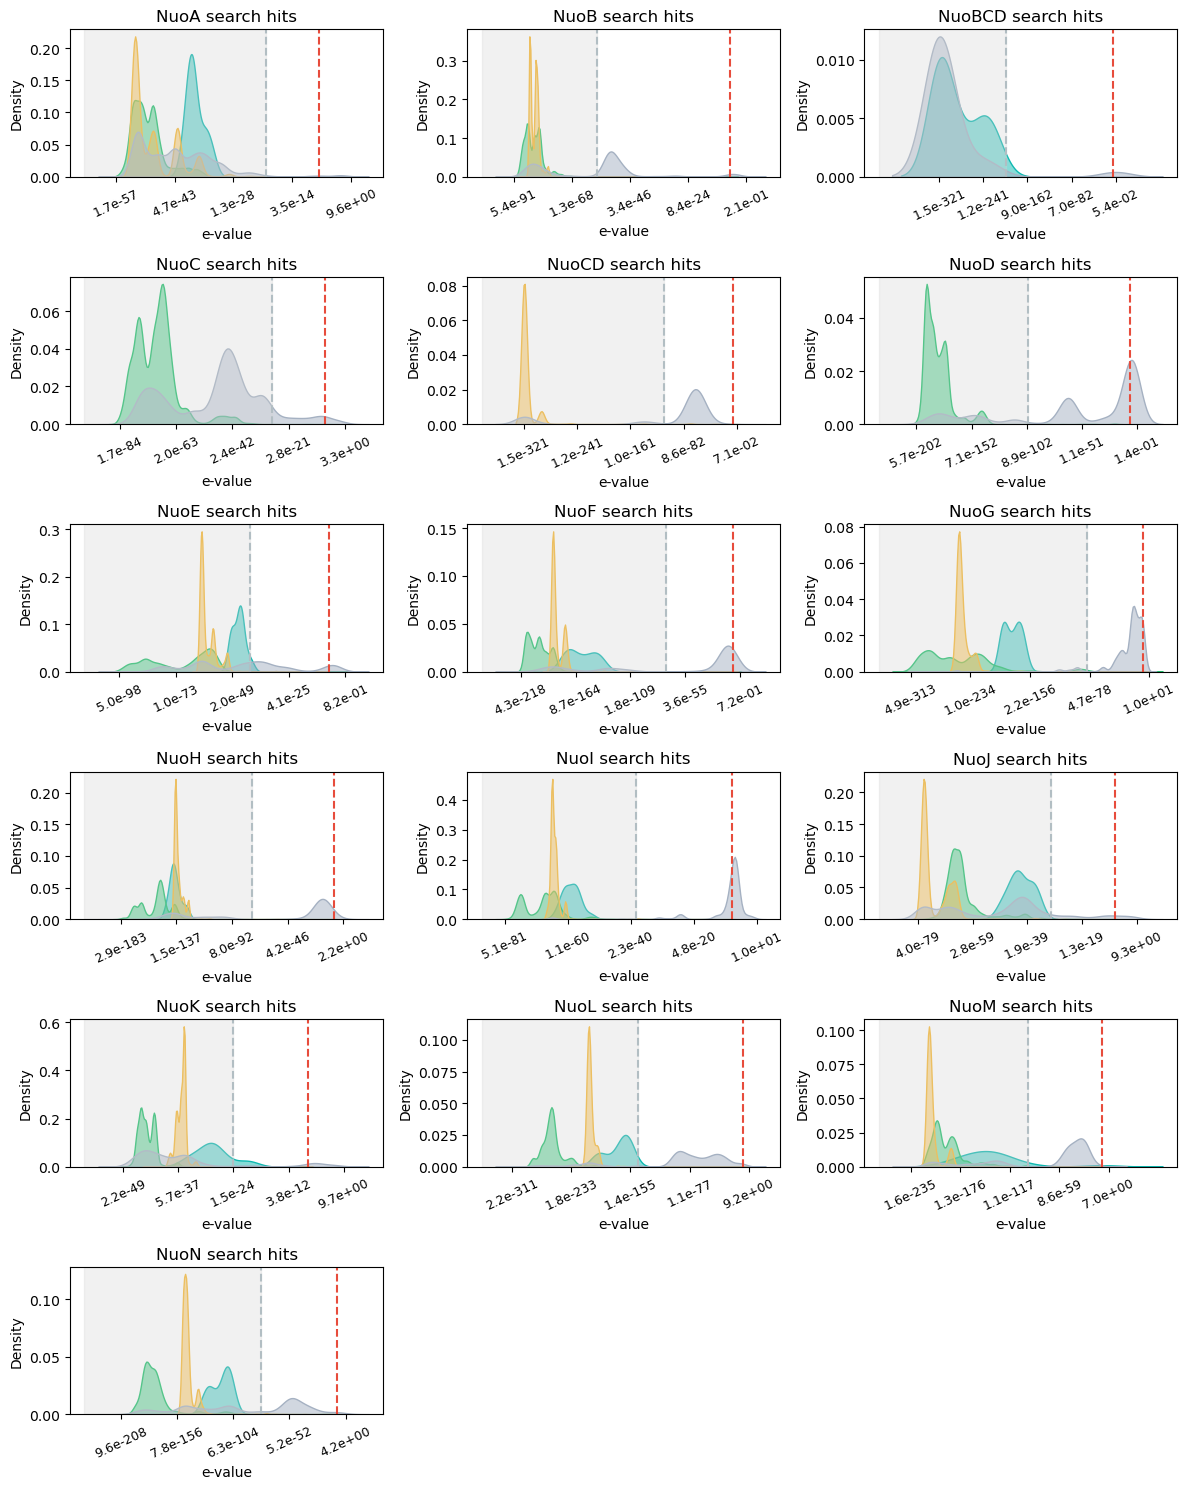

In [16]:
# Ensure required columns exist in both DataFrames
assert {'Accession', 'Cluster', 'Subunit'}.issubset(results.columns), "Missing expected columns in results DataFrame."
assert {'Accession', 'Cluster', 'Variation'}.issubset(nuo_bool.columns), "Missing expected columns in nuo_bool DataFrame."

# Efficiently merge data once for all subunits
subunits_data = pd.concat([
    pd.merge(
        results.reset_index(drop=True), 
        nuo_bool.loc[nuo_bool['Variation'] == arch, ['Accession', 'Cluster', 'Variation']],
        on=['Accession', 'Cluster']
    )[['Accession', 'log10evalue', 'Variation', 'Subunit']]
    for arch in nuo_bool['Variation'].unique()
], ignore_index=True)

# Handle '-inf' values in 'log10evalue' by replacing with a lower bound
finite_values = subunits_data.loc[np.isfinite(subunits_data['log10evalue']), 'log10evalue']
lower_bound = finite_values.min() - 1 if not finite_values.empty else -10  # Default lower bound
subunits_data['log10evalue'].replace(-np.inf, lower_bound, inplace=True)

# Set up figure with 3 columns and 6 rows
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 15), constrained_layout=True)
axes = axes.flatten()  # Flatten axes array for easier indexing

# Iterate over subunits and create KDE plots
for i, subunit in enumerate(subunits):
    ax = axes[i]
    
    # Filter data for the current subunit
    subunit_data = subunits_data[subunits_data['Subunit'] == subunit]

    # Skip empty plots
    if subunits_data.empty:
        ax.set_visible(False)
        continue

    # KDE Plot
    sns.kdeplot(
        data=subunit_data,
        x='log10evalue',
        hue='Variation',
        fill=True,
        common_norm=False,
        palette=complex_colors,
        alpha=0.5,
        ax=ax
    )

    # Vertical threshold line
    ax.axvline(x=-7.0, linestyle='--', color='#e74c3c')
    
    # Set labels and title
    ax.set_title(f'{subunit} search hits', fontsize=12)
    ax.set_xlabel('e-value', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)

    # Set custom tick labels for log-scale interpretation
    log_min = subunit_data['log10evalue'].min()
    log_max = subunit_data['log10evalue'].max()
    log_ticks = np.linspace(log_min, log_max, num=5)
    original_ticks = 10**log_ticks  # Convert log10 values back to original scale

    # Set custom evalue threshold
    ax.axvline(x=evalue_cutoff.get(subunit, 0), linestyle='--', color='#b2bec3')
    
    ax.axvspan(
        xmin=ax.get_xlim()[0],  # Extend shading from the leftmost limit
        xmax=evalue_cutoff.get(subunit, 0),  # Use cutoff value, defaulting to 0 if not found
        color='#d3d3d3', 
        alpha=0.30, 
        zorder=1  # Ensure shaded region is in the background
    )

    
    ax.set_xticks(log_ticks)
    ax.set_xticklabels([f'{v:.1e}' for v in original_ticks], fontsize=9, rotation=25)
    ax.legend_.set_visible(False)
    
# Hide any extra unused subplots
for i in range(len(subunits), len(axes)):
    axes[i].set_visible(False)

# Show plot
plt.tight_layout()
plt.savefig(output_dir / 'evalue_kdeplot_unfil_hits_clustered.png', dpi=750)
plt.savefig(output_dir / 'evalue_kdeplot_unfil_hits_clustered.pdf', format='pdf', dpi=750)
plt.show()